In [28]:
from binance.spot import Spot
import pandas as pd
client = Spot()

In [29]:
symbols = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT", "DOGEUSDT", "MATICUSDT", "SOLUSDT", "DOTUSDT", "LTCUSDT"]

In [30]:
dfs = []

In [31]:
for symbol in symbols:
    # Get last 600 klines of symbol at 1d interval
    rawData = client.klines(symbol=symbol, interval="1d", limit=1000)
    # 4 - close price
    # 6 - close time
    # rawData is a list of lists, each list is a kline, take only 4th, 5th and 6th element in every list
    rawData = [x[4:7] for x in rawData]
    # form a dataframe with close price, volume and close time; close time is key
    df = pd.DataFrame(rawData, columns=[symbol, "volume", "close_time"])
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    df.set_index("close_time", inplace=True)
    df[symbol] = df[symbol].astype(float)
    #drop volume column
    df.drop("volume", axis=1, inplace=True)
    #append to list of dataframes
    dfs.append(df)

In [32]:
#merge all dataframes by index
df = pd.concat(dfs, axis=1)

In [33]:
#calculate returns
df_returns = df.pct_change()
#shift returns by -1 day
df_returns_shifted = df_returns.shift(-1)

In [34]:
#calculate correlation matrix of df_returns removing close_time column
df_corr = df_returns.corr()

<Axes: >

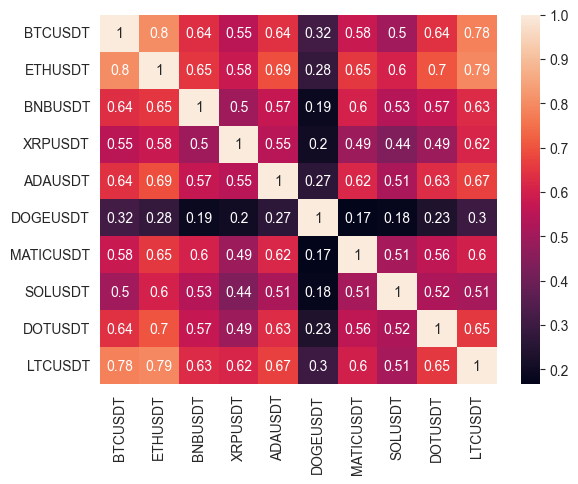

In [35]:
#plot heatmap of correlation matrix
import seaborn as sns
sns.heatmap(df_corr, annot=True)

Below is Factor calculation

In [36]:
#df_moving_average = df.rolling(window=5).mean() - df.rolling(window=10).mean()
#df_factor = df_moving_average.pct_change()

#df_3day = df.shift(3)
#df_3day_pct_change = df / df_3day - 1

#calculate MACD of all symbols with EMA
df_12day = df.ewm(span=12, adjust=True).mean()
df_26day = df.ewm(span=26, adjust=True).mean()
df_macd = df_12day - df_26day
#calculate signal line
df_signal = df_macd.ewm(span=9, adjust=True).mean()
#calculate factor
df_factor = (df_macd - df_signal)
df_factor.dropna(inplace=True)

In [37]:
df_factor

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,MATICUSDT,SOLUSDT,DOTUSDT,LTCUSDT
close_time,,,,,,,,,,
2020-08-18 23:59:59.999,31.421469,2.155133,0.067771,0.000897,-0.000274,6.751703e-07,0.000334,-0.010263,0.000000,0.822084
2020-08-19 23:59:59.999,14.048365,0.623366,0.016528,-0.000033,-0.000703,-5.426062e-06,0.000078,-0.023244,-0.001496,0.646623
2020-08-20 23:59:59.999,7.181238,0.023646,0.020611,-0.000503,-0.000684,-7.967053e-06,0.000008,-0.015872,-0.002342,0.534744
2020-08-21 23:59:59.999,-15.894138,-1.963119,-0.034344,-0.001499,-0.001233,-1.267358e-05,-0.000151,-0.021710,-0.003798,0.232441
2020-08-22 23:59:59.999,-22.753623,-2.760275,-0.062687,-0.001692,-0.001389,-1.194080e-05,-0.000174,-0.019864,0.041502,0.081421
...,...,...,...,...,...,...,...,...,...,...
2023-04-20 23:59:59.999,-235.965359,-5.374620,0.144672,-0.007271,-0.001154,-2.229193e-04,-0.003836,0.032490,-0.022564,-0.356968
2023-04-21 23:59:59.999,-360.809577,-17.291749,-0.530024,-0.010134,-0.004165,-9.062713e-04,-0.009858,-0.141348,-0.063712,-0.964888
2023-04-22 23:59:59.999,-392.422084,-22.889604,-0.261424,-0.010095,-0.005138,-1.192069e-03,-0.012263,-0.214565,-0.080579,-1.203728


In [38]:
# for df_factor, if value is negative, make value 0
df_factor[df_factor<0]=0

In [39]:
df_factor_weight = df_factor.rank(axis=1, ascending=True)

In [40]:
df_factor_weight

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,MATICUSDT,SOLUSDT,DOTUSDT,LTCUSDT
close_time,,,,,,,,,,
2020-08-18 23:59:59.999,10.0,9.0,7.0,6.0,2.0,4.0,5.0,2.0,2.0,8.0
2020-08-19 23:59:59.999,10.0,8.0,7.0,3.0,3.0,3.0,6.0,3.0,3.0,9.0
2020-08-20 23:59:59.999,10.0,8.0,7.0,3.0,3.0,3.0,6.0,3.0,3.0,9.0
2020-08-21 23:59:59.999,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,10.0
2020-08-22 23:59:59.999,4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...
2023-04-20 23:59:59.999,4.5,4.5,10.0,4.5,4.5,4.5,4.5,9.0,4.5,4.5
2023-04-21 23:59:59.999,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5
2023-04-22 23:59:59.999,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5


In [41]:
df_factor_weight[df_factor_weight<8]=0

In [42]:
df_factor_weight[[df_factor_weight>=8]]=1/3

In [43]:
df_factor_weight

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,MATICUSDT,SOLUSDT,DOTUSDT,LTCUSDT
close_time,,,,,,,,,,
2020-08-18 23:59:59.999,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333
2020-08-19 23:59:59.999,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333
2020-08-20 23:59:59.999,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333
2020-08-21 23:59:59.999,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333
2020-08-22 23:59:59.999,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...
2023-04-20 23:59:59.999,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000
2023-04-21 23:59:59.999,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2023-04-22 23:59:59.999,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [44]:
#for every day, use df_moving_average_pct_change_rank to calculate portfolio return
df_portfolio_returns = df_returns_shifted * df_factor_weight
df_portfolio_returns = df_portfolio_returns.sum(axis=1)

<Axes: xlabel='close_time'>

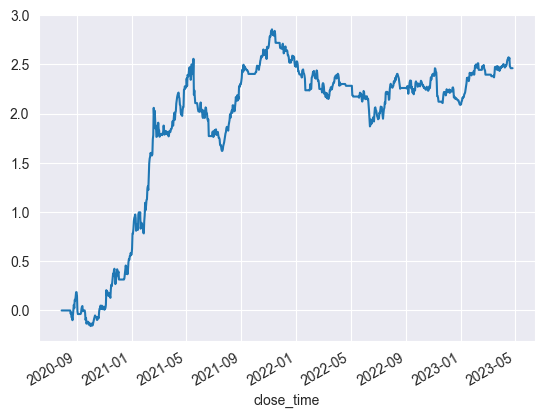

In [45]:
#plot portfolio returns with cumulative sum
df_portfolio_returns.cumsum().plot()

<Axes: xlabel='close_time'>

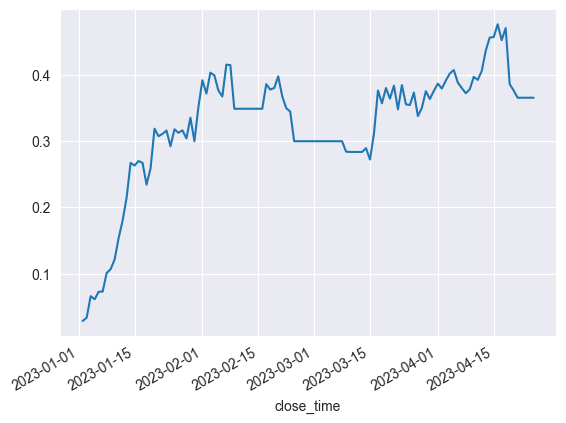

In [46]:
#plot portfolio returns from 2023 Jan to 2023 May
df_portfolio_returns["2023-01-01":"2023-05-01"].cumsum().plot()

<Axes: xlabel='close_time'>

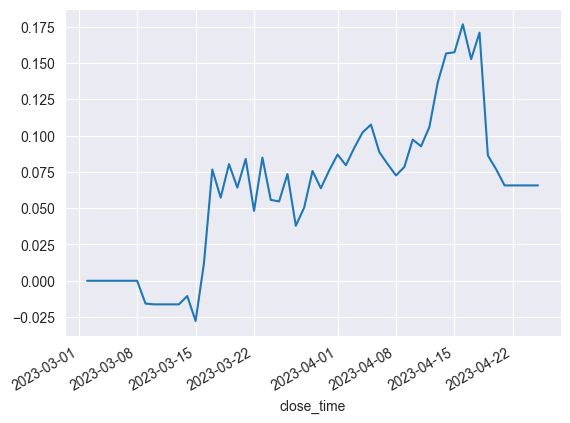

In [47]:
df_portfolio_returns["2023-03-01":"2023-05-01"].cumsum().plot()

In [48]:
#calculate YTD max drawdown
df_portfolio_returns["2023-01-01":"2023-05-01"].min()

-0.0845482752123794